<a href="https://colab.research.google.com/github/qtncyy/229352-StatisticalLearning/blob/main/660510740_Lab09_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #9

In [96]:
%%capture
!git clone https://github.com/donlapark/ds352-labs.git

In [97]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

## Training a neural network in PyTorch

### Chihuahua or Muffin?

<center><img src="https://donlapark.pages.dev/229352/lab09-preview.jpg" width="500"/></center>

### 1. Data preparation

#### Load images, resize them to 128x128, and normalize the pixels to be in 0 - 1 range

In [98]:
transform = transforms.Compose([transforms.Resize((128, 128)),
                                transforms.ToTensor()])  # transform pixels to be in 0 - 1 range

dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/train",
                                         transform=transform)

#### Split the dataset into training (80%), validation (20%)

In [99]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

#### Load the datasets into DataLoader

In [100]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=10,
                          shuffle=True)
val_loader = DataLoader(dataset=val_dataset,
                        batch_size=len(val_dataset),
                        shuffle=False)

#### Do the same for the test images

In [101]:
test_dataset = datasets.ImageFolder(root="ds352-labs/lab09-data/test",
                                    transform=transform)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=len(test_dataset),
                         shuffle=False)

#### Looking at the first minibatch

In [102]:
train_loader

In [103]:
train_batches = iter(train_loader)
X, y = next(train_batches)

print(X.shape)  # (batch_size, channel, height, weight)
print(y.shape)

torch.Size([10, 3, 128, 128])
torch.Size([10])


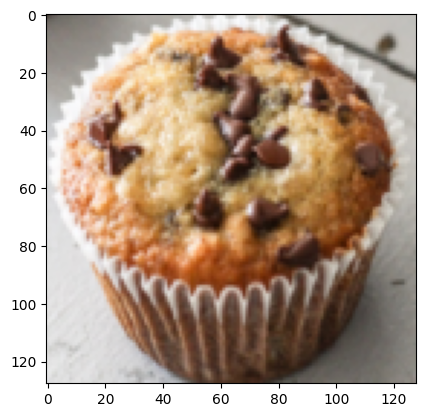

In [104]:
plt.imshow(X[0].numpy().transpose(1, 2, 0))


#### Visualize the first four images in the batch

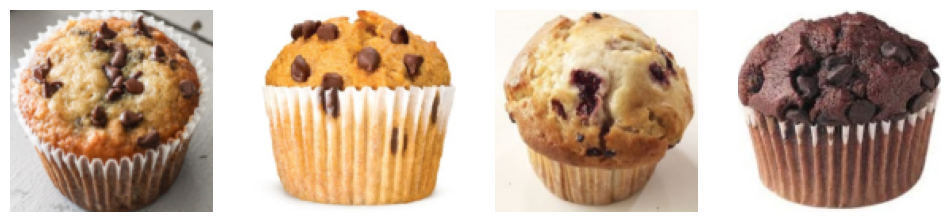

tensor([1, 1, 1, 1])


In [105]:
X = X[:4]  # Select the first 4 images
X = X.numpy().transpose(0, 2, 3, 1)  # Convert from (B, C, H, W) to (B, H, W, C)

# Plot images
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i in range(4):
    axes[i].imshow(X[i])
    axes[i].axis('off')
plt.show()

print(y[:4])

### 2. Build a simple logistic regression

<center><img src="https://donlapark.pages.dev/229352/logistic.png" width="300"/></center>

The most important component of the model class is the `__init__` method and the `forward` method.  
  
[Activation functions in PyTorch](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity). The most important ones are [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html), [Sigmoid](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html), [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html).

In [106]:
class SimpleLogisticRegression(nn.Module):
  def __init__(self):
    super(SimpleLogisticRegression, self).__init__()
    self.flatten = nn.Flatten()
    self.linear1 = nn.Linear(128 * 128 * 3, 1)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.flatten(x)
    x = self.linear1(x)
    x = self.sigmoid(x)
    return x

### 3. Initialize training components

#### Initialize the model and loss function

[Loss functions in PyTorch](https://pytorch.org/docs/stable/nn.html#loss-functions). Most important ones are [MSE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html), [Binary cross, entropy](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), [Categorical cross entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html).

In [107]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

#### Manually setting initial weights to zero for demonstration

In [108]:
with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

#### Create two lists to collect training and validation losses

In [109]:
# List to store the loss values for plotting
train_losses = []
val_losses = []

#### Specify the learning rate

In [110]:
learning_rate = 1e-3

### 4. Training the model with gradient descent

#### Convert the dataloader into minibatches

In [111]:
train_batches = iter(train_loader)
X, y = next(train_batches)

In [112]:
X, y = next(train_batches)


#### Make a prediction on the minibatch (Forward pass)

In [113]:
y_hat = model(X)
print(y_hat.shape)
print(y.shape)

y_hat = y_hat[:, 0]
y = y.to(torch.float32) #

torch.Size([10, 1])
torch.Size([10])

torch.Size([10, 1])
torch.Size([10])


torch.Size([10])

#### Calculate the loss function

Recall that `criterion()` is our binary cross-entropy loss (`BCELoss`).

In [114]:
# Compute the loss
loss = criterion(y_hat, y)
train_losses.append(loss.item())

#### Calculate the gradient (Backward pass)

In [115]:
# Backward pass: compute the gradient of the loss w.r.t. model parameters
loss_backward = loss.backward()

In [116]:
for param in model.parameters():
  print(param)

Parameter containing:
tensor([[0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [117]:
for param in model.parameters():
  print(param.grad)

tensor([[ 0.0182,  0.0225,  0.0184,  ..., -0.0598, -0.0525, -0.0459]])
tensor([0.1000])


#### Perform a gradient descent step

Careful! We must not include this step in the gradient calculation, hence the use of `with torch.no_grad()`.

In [118]:
# Manually update the weights using the gradient descent rule

with torch.no_grad():
    for param in model.parameters():
        param -= learning_rate * param.grad
# Zero the gradients after updating
model.zero_grad()

#### Do the same for the validation set

Careful! Anything in the validation step must not be included in the gradient calculation, hence the use of `with torch.no_grad()`.

In [119]:
with torch.no_grad():
  for X, y in val_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)
    val_loss = criterion(y_hat, y)
    val_losses.append(val_loss.item())

In [120]:
print(train_losses)
print(val_losses)

[0.6931471824645996]
[0.6987360119819641]


#### Combine everything together.

Repeat the previous steps for 20 **epochs** and plot the training and validation losses.

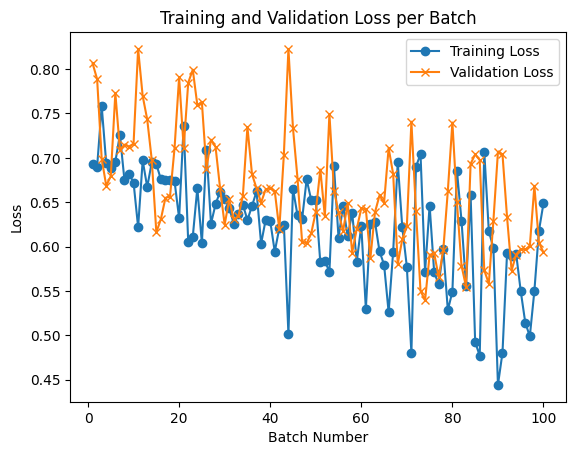

In [121]:
model = SimpleLogisticRegression()
criterion = nn.BCELoss()

with torch.no_grad():
  for layer in model.modules():
      if isinstance(layer, nn.Linear):
          layer.weight.zero_()
          layer.bias.zero_()

train_losses = []
val_losses = []

learning_rate = 1e-4

for epoch in range(10):
  for X, y in train_loader:
    y_hat = model(X)
    y_hat = y_hat[:, 0]
    y = y.to(torch.float32)

    loss = criterion(y_hat, y)
    train_losses.append(loss.item())

    loss.backward()

    with torch.no_grad():
        for param in model.parameters():
            param -= learning_rate * param.grad

    # Zero the gradients after updating
    model.zero_grad()

    with torch.no_grad():
      for X, y in val_loader:
        y_hat = model(X)
        y_hat = y_hat[:, 0]
        y = y.to(torch.float32)
        val_loss = criterion(y_hat, y)
        val_losses.append(val_loss)

# Plot the training and validation loss
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses)+1), val_losses, marker='x', label='Validation Loss')
plt.title('Training and Validation Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Exercise

In this exercise, we will add more layers to our classification model.

<img src="https://donlapark.pages.dev/229352/lab09-architecture.png" width="450"/>

1. Create a neural network with 3 hidden layers as shown in the picture.

2. Train the model with learning rate = 1e-2, 1e-3, 1e-4, 1e-5, and answer the following questions.
    2.1 What value of learning rate do you **think** is the best? Please explain your reason.
    2.2 What happens to the training losses if your learning rate is too large?
    2.3 What happens to the training losses if your learning rate is too small?

3. After finish training your model. Make the predictions on the test set and compute the accuracy. You may use the provided code below.

4. Use `plt.imshow()` to display at least four images that are incorrectly classified by this model.

In [122]:
# Use this code to calculate test accuracy
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  y_hat = model(X)
  y_hat = y_hat[:, 0]
  y_hat = (y_hat > 0.5).float()  # the predictions
  ##TODO: compute accuracy


# 1.

In [123]:
class ThreeLayerNet(nn.Module):
    def __init__(self):
        super(ThreeLayerNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(128 * 128 * 3, 128)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(64, 32)
        self.relu3 = nn.ReLU()
        self.linear4 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu1(x)
        x = self.linear2(x)
        x = self.relu2(x)
        x = self.linear3(x)
        x = self.relu3(x)
        x = self.linear4(x)
        x = self.sigmoid(x)
        return x

In [124]:
def train_model(model, criterion, train_loader, val_loader, learning_rate, num_epochs):
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_train_loss = 0.0
        for X, y in train_loader:
            y_hat = model(X)
            y_hat = y_hat[:, 0]
            y = y.to(torch.float32)

            loss = criterion(y_hat, y)
            running_train_loss += loss.item()

            loss.backward()

            with torch.no_grad():
                for param in model.parameters():
                    param -= learning_rate * param.grad

            model.zero_grad()

        epoch_train_loss = running_train_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        model.eval() # Set model to evaluation mode
        running_val_loss = 0.0
        with torch.no_grad():
            for X, y in val_loader:
                y_hat = model(X)
                y_hat = y_hat[:, 0]
                y = y.to(torch.float32)
                val_loss = criterion(y_hat, y)
                running_val_loss += val_loss.item()

        epoch_val_loss = running_val_loss / len(val_loader)
        val_losses.append(epoch_val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}')


    return train_losses, val_losses

In [125]:
learning_rates = [1e-2, 1e-3, 1e-4, 1e-5]
train_losses_dict = {}
val_losses_dict = {}

In [126]:
num_epochs = 20

for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = ThreeLayerNet()
    criterion = nn.BCELoss()
    train_losses, val_losses = train_model(model, criterion, train_loader, val_loader, lr, num_epochs)
    train_losses_dict[lr] = train_losses
    val_losses_dict[lr] = val_losses

Training with learning rate: 0.01
Epoch 1/20, Train Loss: 0.6930, Val Loss: 0.7029
Epoch 2/20, Train Loss: 0.6839, Val Loss: 0.7391
Epoch 3/20, Train Loss: 0.6860, Val Loss: 0.6788
Epoch 4/20, Train Loss: 0.6677, Val Loss: 0.7030
Epoch 5/20, Train Loss: 0.6496, Val Loss: 0.6629
Epoch 6/20, Train Loss: 0.6333, Val Loss: 0.8041
Epoch 7/20, Train Loss: 0.6289, Val Loss: 0.6533
Epoch 8/20, Train Loss: 0.6141, Val Loss: 0.7547
Epoch 9/20, Train Loss: 0.5642, Val Loss: 0.5750
Epoch 10/20, Train Loss: 0.5751, Val Loss: 0.5922
Epoch 11/20, Train Loss: 0.5587, Val Loss: 0.7363
Epoch 12/20, Train Loss: 0.5016, Val Loss: 0.4722
Epoch 13/20, Train Loss: 0.5609, Val Loss: 1.1357
Epoch 14/20, Train Loss: 0.4944, Val Loss: 0.4541
Epoch 15/20, Train Loss: 0.4488, Val Loss: 0.4758
Epoch 16/20, Train Loss: 0.5070, Val Loss: 0.5927
Epoch 17/20, Train Loss: 0.5274, Val Loss: 0.4229
Epoch 18/20, Train Loss: 0.3864, Val Loss: 0.6394
Epoch 19/20, Train Loss: 0.3005, Val Loss: 0.4778
Epoch 20/20, Train Loss: 

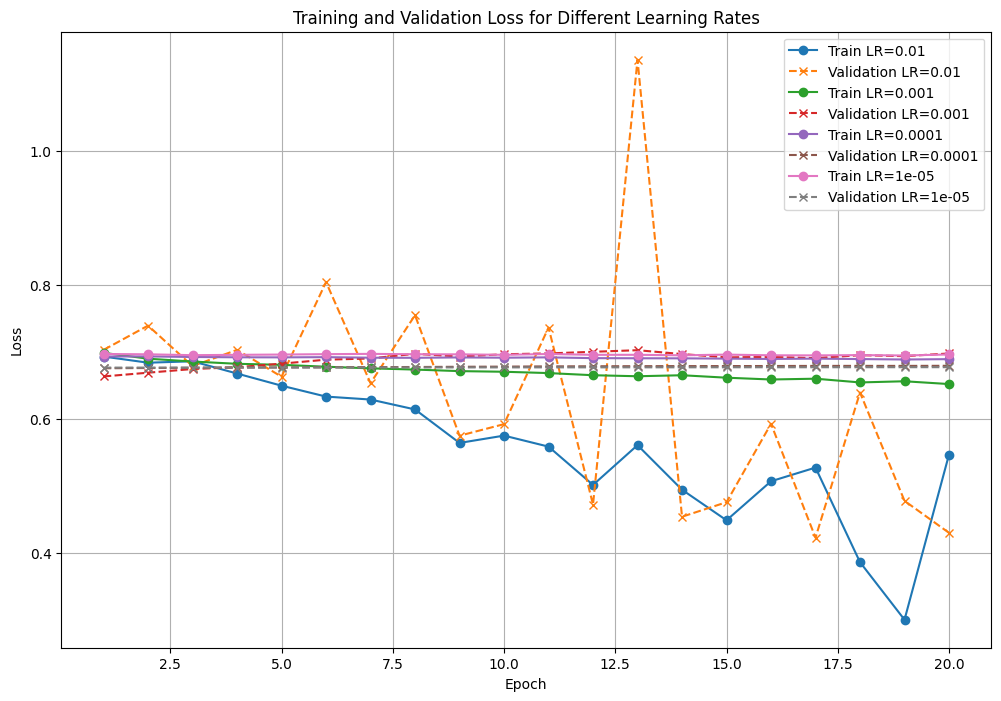

In [127]:
plt.figure(figsize=(12, 8))

for lr in learning_rates:
    plt.plot(range(1, num_epochs + 1), train_losses_dict[lr], marker='o', linestyle='-', label=f'Train LR={lr}')
    plt.plot(range(1, num_epochs + 1), val_losses_dict[lr], marker='x', linestyle='--', label=f'Validation LR={lr}')

plt.title('Training and Validation Loss for Different Learning Rates')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

2.1 What value of learning rate do you **think** is the best? Please explain your reason.

**ANS:** ค่า learning rate = 1e-3 ดูเหมือนจะดีที่สุด เพราะทั้ง training และ validation loss ลดสม่ำเสมอ และ validation loss คงที่ในค่าที่ค่อนข้างต่ำ โดยไม่มีการแกว่งหรือ overfitting เหมือนกับค่า learning rate ที่สูงกว่า


---



2.2 What happens to the training losses if your learning rate is too large?

**ANS:**  Loss จะแกว่งขึ้นลงรุนแรง หรือ พุ่งสูงแบบ spike เห็นได้จาก Validation LR=0.01 ที่บางจุด loss กระโดดขึ้นสูงมาก และโมเดลอาจ ไม่ converge และบางครั้งทำให้ผลลัพธ์แย่ลง เพราะก้าวการอัปเดตพารามิเตอร์ใหญ่เกินไปจนข้าม minimum ไปเรื่อยๆ



---


2.3 What happens to the training losses if your learning rate is too small?

**ANS:** Loss จะ ลดลงช้ามากหรือแทบไม่เปลี่ยนแปลงเลย และโมเดลใช้เวลานานในการ converge และอาจติดอยู่ใน local minima ทำให้ได้ผลลัพธ์ที่ไม่ดีนักภายในจำนวน epoch ที่จำกัด


# 3.

In [128]:
# Use this code to calculate test accuracy
with torch.no_grad():
  test_batches = iter(test_loader)
  X, y = next(test_batches)
  y_hat = model(X)
  y_hat = y_hat[:, 0]
  y_hat = (y_hat > 0.5).float()  # the predictions
  #TODO: compute accuracy
  correct_predictions = (y_hat == y).sum().item()
  len_y = len(y)
  accuracy = correct_predictions / len_y
  print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.5667


# 4.

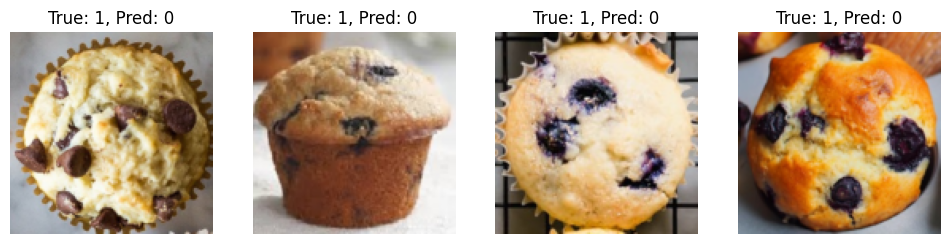

In [129]:
# Find misclassified images
misclassified_indices = (y_hat != y).nonzero(as_tuple=True)[0]

# Select 4 misclassified images
num_images_to_display = min(len(misclassified_indices), 4)
display_indices = misclassified_indices[:num_images_to_display]

# Get the misclassified images and their true and predicted labels
misclassified_images = X[display_indices].numpy().transpose(0, 2, 3, 1)
true_labels = y[display_indices]
predicted_labels = y_hat[display_indices]

fig, axes = plt.subplots(1, num_images_to_display, figsize=(12, 4))
for i in range(num_images_to_display):
    axes[i].imshow(misclassified_images[i])
    axes[i].set_title(f"True: {int(true_labels[i])}, Pred: {int(predicted_labels[i])}")
    axes[i].axis('off')
plt.show()